In [1]:
from catchment import create_catchment, netcdf_from_dict
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from netCDF4 import Dataset, date2num
from datetime import datetime

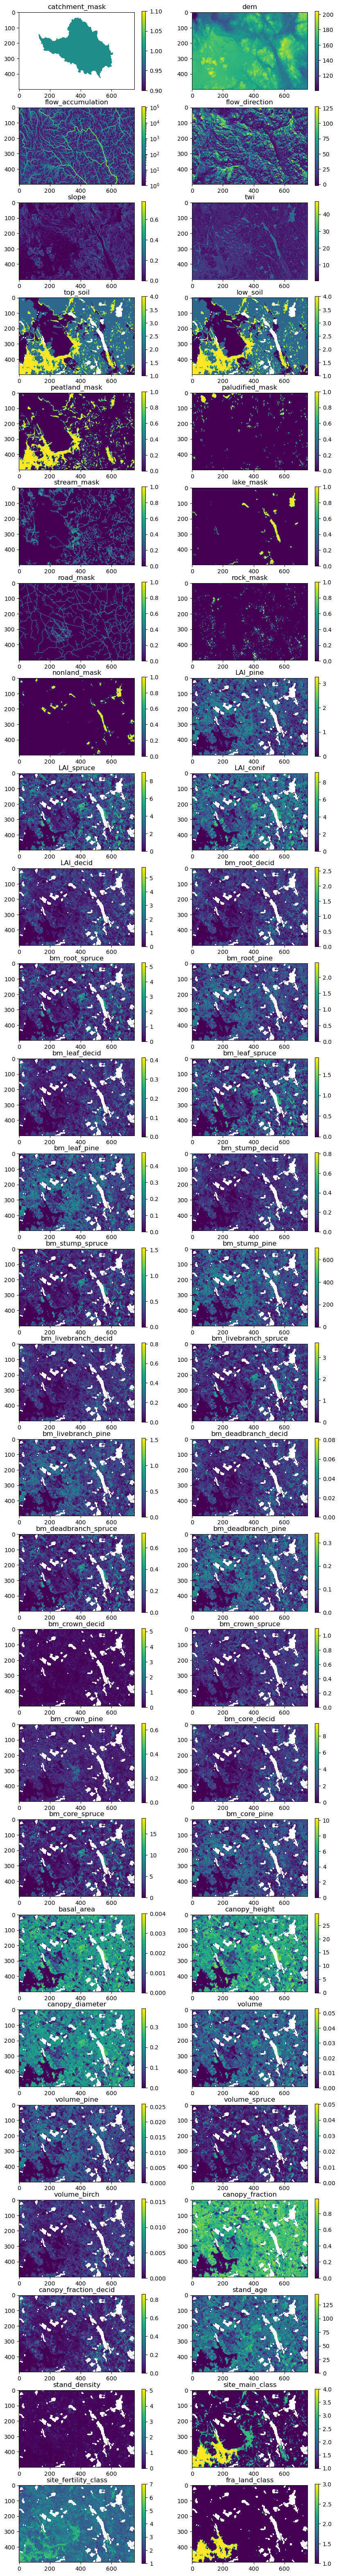

In [2]:
fpath = r'/scratch/project_2000908/nousu/GISPUTS/Kuivalake_Catchment/GIS_inputs/kuivajarvi/'
catch, units, meta = create_catchment(fpath, set_non_forest_as='nan')

In [ ]:
data = {}
data['DEM'] = catch['dem']
data['LAI'] = catch['LAI_conif'] + catch['LAI_decid']
data['CH'] = catch['canopy_height']

In [10]:
def lad_constant(z: np.ndarray, LAI: float, h: float, hb: float=0.0):
    """
    Creates uniform leaf-area density distribution.

    Args:
        z (array): [m] monotonically increasing, constant step
        LAI (float): [m2 m-2] leaf-area index
        h (float): [m] canopy height
        hb (float): [m] crown base height
    Returns:
        LAD (array): [m2 m-3] leaf-area density

    """
    if max(z) <= h:
        raise ValueError("h must be lower than uppermost gridpoint")

    z = np.array(z)
    dz = abs(z[1]-z[0])
    N = np.size(z)
    
    # dummy variables
    a = np.zeros(N)
    ix = np.where( (z > hb) & (z <= h)) [0]
    if ix.size == 0:
        ix = [1]

    a[ix] = 1.0
    a = a / sum(a*dz)
    LAD = LAI * a

    return LAD

In [244]:
dz = 1 # vertical interval
ch = np.nanmax(data['CH']) # max height of the raster
z = np.arange(0, ch+dz, dz) # vertical grid
hb = 0 # crown base height

# 3D array for LAD
LAD_arr = np.zeros(shape=(data['LAI'].shape[0], data['LAI'].shape[1], np.size(z)))

for i in range(data['LAI'].shape[0]):
    for j in range(data['LAI'].shape[1]):
        LAI_temp = data['LAI'][i,j]
        CH_temp = data['CH'][i,j]
        LAD_temp = lad_constant(z=z, LAI=LAI_temp, h=CH_temp, hb=hb)
        LAD_arr[i,j,:] = LAD_temp

In [262]:
LAD_arr_s = LAD_arr[300:500,450:650,:]#[0:100,0:100,:-1]
LAD_arr_s[LAD_arr_s == 0] = np.nan

In [264]:
x = np.arange(0, LAD_arr_s.shape[0], 1)
y = np.arange(0, LAD_arr_s.shape[1], 1)
z = np.arange(0, LAD_arr_s.shape[2], 1)

X, Y, Z = np.meshgrid(x, y, z)

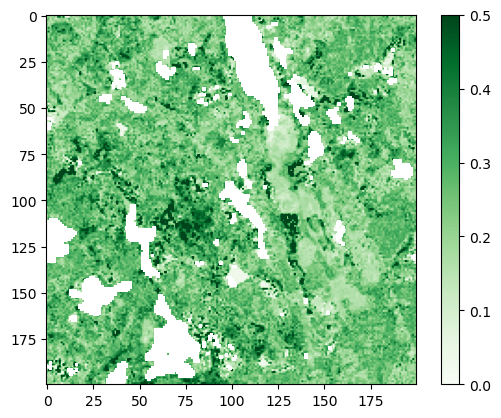

In [272]:
#window = [175:375,500:700,1]
plt.imshow(LAD_arr[300:500,450:650,1], cmap='Greens', vmin=0, vmax=0.5); plt.colorbar()
#plt.imshow(LAD_arr[:,:,5], cmap='Greens', vmin=0, vmax=0.5); plt.colorbar()

#plt.imshow(data['CH'][175:375,500:700], cmap='Greens'); plt.colorbar()


In [219]:
%matplotlib inline

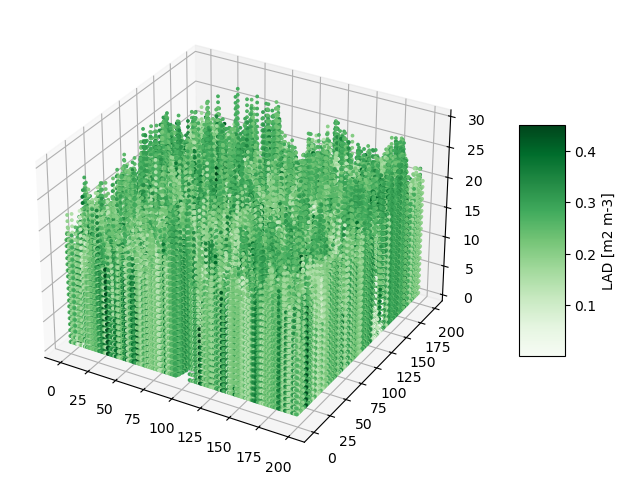

In [270]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')
scat = ax.scatter(X, Y, Z, c=LAD_arr_s.flatten(), cmap='Greens', alpha=1, s=3, vmax=0.45)
#ax.set_xlabel('x')
#ax.set_ylabel('y')
#ax.set_zlabel('z')
cbar = fig.colorbar(scat, shrink=0.5, aspect=5)
cbar.set_label('LAD [m2 m-3]')

In [285]:
z.shape[0]

31

In [288]:
ncf.close()

out_fp = r'/scratch/project_2000908/nousu/GISPUTS/Kuivalake_Catchment/GIS_inputs/kuivajarvi/lad_grid.nc'

# dimensions
date_dimension = None
lat_shape, lon_shape = np.shape(catch['catchment_mask'])
z_shape = z.shape[0]
xllcorner = int(float(catch['info'][2].split()[1]))
yllcorner = int(float(catch['info'][3].split()[1]))
cellsize = int(float(catch['info'][4].split()[1]))

xcoords = np.arange(xllcorner, (xllcorner + (lon_shape*cellsize)), cellsize)
ycoords = np.arange(yllcorner, (yllcorner + (lat_shape*cellsize)), cellsize)
ycoords = np.flip(ycoords)

description = ''

# create dataset and dimensions
ncf = Dataset(out_fp, 'w', format='NETCDF4_CLASSIC')
ncf.description = 'LAD dataset' + description
ncf.history = 'created ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
ncf.source = ''

#ncf.createDimension('time', date_dimension)
ncf.createDimension('lat', lat_shape)
ncf.createDimension('lon', lon_shape)
ncf.createDimension('z', z_shape)

#date = ncf.createVariable('time', 'f8', ('time',))
#date.units = 'days since 0001-01-01 00:00:00.0'
#date.calendar = 'standard'
#tvec = pd.date_range(pgen['spinup_end'], pgen['end_date']).tolist()[1:]
#date[:] = date2num(tvec, units=date.units, calendar=date.calendar)

ivar = ncf.createVariable('lat', 'f8', ('lat',))
ivar.units = 'ETRS-TM35FIN'
ivar[:] = ycoords

jvar = ncf.createVariable('lon', 'f8', ('lon',))
jvar.units = 'ETRS-TM35FIN'
jvar[:] = xcoords

zvar = ncf.createVariable('z', 'f8', ('z',))
zvar.units = 'm'
zvar[:] = z

dem_dim = ('lat', 'lon')
dem_var = ncf.createVariable(
            'DEM', 'f4', dem_dim)
dem_var.units = 'm'

ncf['DEM'][:,:] = data['DEM']

lad_dim = ('lat', 'lon', 'z')
lad_var = ncf.createVariable(
            'LAD', 'f4', lad_dim)
lad_var.units = 'm2 m-3'

ncf['LAD'][:,:,:] = LAD_arr[:,:,:]

ncf.close()

In [5]:
import xarray as xr

fp = r'/scratch/project_2000908/nousu/GISPUTS/Kuivalake_Catchment/GIS_inputs/kuivajarvi/lad_grid.nc'
data = xr.open_dataset(fp)

In [6]:
print(data)

<xarray.Dataset>
Dimensions:  (lat: 500, lon: 750, z: 31)
Coordinates:
  * lat      (lat) float64 6.865e+06 6.865e+06 6.865e+06 ... 6.857e+06 6.857e+06
  * lon      (lon) float64 3.48e+05 3.48e+05 3.48e+05 ... 3.6e+05 3.6e+05
  * z        (z) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 26.0 27.0 28.0 29.0 30.0
Data variables:
    DEM      (lat, lon) float32 ...
    LAD      (lat, lon, z) float32 ...
Attributes:
    description:  LAD dataset
    history:      created 2023-12-20 12:54:35
    source:       


In [294]:
d['DEM']

<xarray.DataArray 'DEM' (lat: 500, lon: 750)>
[375000 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 6.865e+06 6.865e+06 6.865e+06 ... 6.857e+06 6.857e+06
  * lon      (lon) float64 3.48e+05 3.48e+05 3.48e+05 ... 3.6e+05 3.6e+05
Attributes:
    units:    m

In [293]:
d['LAD']

<xarray.DataArray 'LAD' (lat: 500, lon: 750, z: 31)>
[11625000 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 6.865e+06 6.865e+06 6.865e+06 ... 6.857e+06 6.857e+06
  * lon      (lon) float64 3.48e+05 3.48e+05 3.48e+05 ... 3.6e+05 3.6e+05
  * z        (z) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 26.0 27.0 28.0 29.0 30.0
Attributes:
    units:    m2 m-3